In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from collections import OrderedDict
from datetime import datetime

import functools
import dask
from dask import compute, delayed
from itertools import chain
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

import sklearn
import scipy as sp
import math
import seaborn as sns
import statsmodels

import warnings
warnings.filterwarnings('ignore')

from jqdatasdk import *
# auth('13116179525','179525')
auth('18602656266','656266')
# auth('13726274782','274782')

提示：当前环境pandas版本为0.25，get_price与get_fundamentals_continuously接口panel参数将固定为False
注意：0.25以上版本pandas不支持panel，如使用该数据结构和相关函数请注意修改
auth success 


In [2]:
all_stocks_list = list(get_all_securities(['stock']).index)

all_indexes_list = list(get_all_securities(['index']).index)

all_etf = list(get_all_securities(['etf']).index)

HS300_stock_list = get_index_stocks('000300.XSHG')
SZ_stock_list = get_index_stocks('000001.XSHG')

# normalize_code(['000001', 'SZ000001', '000001SZ', '000001.sz', '000001.XSHE'])

rz_stock_list = get_margincash_stocks(date='2019-01-01')
rq_stock_list = get_marginsec_stocks(date='2019-01-01')

# weights
wt = get_index_weights('000300.XSHG', date='2019-01-01')

concept_dict = {}
for i in range(0, len(get_concepts())):
    concept_dict[get_concepts().name.index[i]] = get_concepts().name.values[i]

# get_concept(security, date=None)
# get_concept_stocks

industry_dict = {}
for i in range(0, len(get_industries())):
    industry_dict[get_industries().name.index[i]] = get_industries().name.values[i]
    
# get_industry(security, date=None)
# get_industry_stocks

In [3]:
industry_dict

{'L72': '商务服务业',
 'L71': '租赁业',
 'G53': '铁路运输业',
 'G57': '管道运输业',
 'G56': '航空运输业',
 'G55': '水上运输业',
 'G54': '道路运输业',
 'G59': '仓储业',
 'P82': '教育',
 'C43': '金属制品、机械和设备修理业',
 'O80': '机动车、电子产品和日用产品修理业',
 'O81': '其他服务业',
 'D46': '水的生产和供应业',
 'D45': '燃气生产和供应业',
 'D44': '电力、热力生产和供应业',
 'A02': '林业',
 'A03': '畜牧业',
 'A04': '渔业',
 'A05': '农、林、牧、渔服务业',
 'C39': '计算机、通信和其他电子设备制造业',
 'C38': '电气机械和器材制造业',
 'C35': '专用设备制造业',
 'C34': '通用设备制造业',
 'C37': '铁路、船舶、航空航天和其他运输设备制造业',
 'C36': '汽车制造业',
 'C31': '黑色金属冶炼和压延加工业',
 'C30': '非金属矿物制品业',
 'C33': '金属制品业',
 'C32': '有色金属冶炼和压延加工业',
 'G58': '装卸搬运和运输代理业',
 'K70': '房地产业',
 'S90': '综合',
 'Q83': '卫生',
 'Q84': '社会工作',
 'A01': '农业',
 'F52': '零售业',
 'F51': '批发业',
 'C22': '造纸和纸制品业',
 'C23': '印刷和记录媒介复制业',
 'C20': '木材加工和木、竹、藤、棕、草制品业',
 'C21': '家具制造业',
 'C26': '化学原料和化学制品制造业',
 'C27': '医药制造业',
 'C24': '文教、工美、体育和娱乐用品制造业',
 'C25': '石油加工、炼焦和核燃料加工业',
 'C28': '化学纤维制造业',
 'C29': '橡胶和塑料制品业',
 'H61': '住宿业',
 'H62': '餐饮业',
 'C40': '仪器仪表制造业',
 'C41': '其他制造业',
 'C42': '废弃资源综合利用业',


In [8]:
c15_stocks_prices

,open,close,high,low,volume,money
2020-11-02 09:31:00,209.96,212.59,213.00,209.18,73600.0,15538273.0
2020-11-02 09:32:00,212.60,213.35,213.90,212.49,43900.0,9352806.0
2020-11-02 09:33:00,213.79,212.00,213.79,212.00,37800.0,8038089.0
2020-11-02 09:34:00,212.00,211.55,212.00,211.00,18900.0,3995175.0
2020-11-02 09:35:00,211.97,211.95,211.97,211.56,13800.0,2922049.0
...,...,...,...,...,...,...
2020-11-27 14:56:00,213.77,213.80,213.80,213.77,9300.0,1989255.0
2020-11-27 14:57:00,213.79,213.80,213.80,213.79,13900.0,2971768.0
2020-11-27 14:58:00,213.80,213.80,213.80,213.80,100.0,21380.0
2020-11-27 14:59:00,213.80,213.80,213.80,213.80,0.0,0.0


In [13]:
start_date = '2020-11-02'
end_date = '2020-11-30'


stock_list =  get_industry_stocks('C15')
c15_stocks_prices = get_price(stock_list[1], start_date=start_date, end_date=end_date, frequency='1m')
date_list = c15_stocks_prices.index.strftime("%Y-%m-%d").unique()

def Daily_PnL(date, stock_index, start_date, end_date, frequency, threshold=0.001, transaction_fee=0.0003, tax=0.001):
    
    # get the data
    stock = stock_list[stock_index]
    print("Stock Code: ", stock)
    
    all_stock_price = get_price(stock, start_date=start_date, end_date=end_date, frequency=frequency)
    ret =  all_stock_price.close.pct_change()
    all_stock_price['ret'] = ret
    all_stock_price.dropna(inplace=True)
    
    date_str = all_stock_price.index.strftime("%Y-%m-%d")
    all_stock_price['date'] = date_str
    
    date_list = date_str.unique()
    
    all_stock_price['threshold'] = threshold
    all_stock_price['signal'] = 0
    
    all_stock_price['able'] = 1
    for i in range(0, len(all_stock_price)):
        if all_stock_price['volume'][i] <= 0.:
            all_stock_price['able'][i] = 0
            
    for i in range(0, len(all_stock_price)):
        if (all_stock_price['ret'][i] > all_stock_price['threshold'][i]) & (all_stock_price['able'][i] != 0):
            all_stock_price['signal'][i] = 1
        elif (all_stock_price['ret'][i] <= -all_stock_price['threshold'][i]) & (all_stock_price['able'][i] != 0):
            all_stock_price['signal'][i] = -1
            
    all_stock_price['next.ask'] = all_stock_price['open'].shift(-1) + 0.01
    all_stock_price['next.bid'] = all_stock_price['open'].shift(-1) - 0.01
    
    # set the position for each day
    print("Looking at date: {}".format(date))
    stock_price = all_stock_price[all_stock_price['date'] == date]
    
    print("Number of positive: {}, Number of negative: {}".format(sum(stock_price['ret'] > 0), sum(stock_price['ret'] < 0)))
    n_bar = len(stock_price)
    
    position = stock_price.signal
    position[0] = 0
    position[n_bar-1] = 0 
    position[n_bar-2] = 0
    change_of_position = position - position.shift(1)
    change_of_position[0] = 0
    change_base = np.zeros(n_bar)
    change_buy = np.array(change_of_position>0)
    change_sell = np.array(change_of_position<0)

    change_base[change_buy] = stock_price["next.ask"][change_buy]*(1+transaction_fee)
    change_base[change_sell] = stock_price["next.bid"][change_sell]*(1+transaction_fee+tax)

    stock_price.dropna(inplace=True)

    final_pnl = -sum(change_base*change_of_position) 
    turnover = sum(change_base*abs(change_of_position))
    num = sum((position!=0) & (change_of_position!=0))
    hld_period = sum(position!=0)
    
    result = {
        'name': stock, "date":date, "final.pnl": final_pnl, 
        "turnover": turnover, "num": num, "hld.period": hld_period
    }
    print(result)
    
    return result

def PnL_Result_Plot(date_list, stock_index, start_date, end_date, frequency, 
                    threshold=0.001, transaction_fee=0.0003, tax=0.001, spread=1):
    

    result_df = pd.DataFrame()
    for date in date_list:
        result = Daily_PnL(date, stock_index, start_date, end_date, '1m', 
                        threshold=0.001, transaction_fee=0.0003, tax=0.001)
        df = pd.DataFrame.from_dict(result,orient='index').T.set_index('name')
        
        result_df = result_df.append(df)
    
    statistics = np.array(np.rec.fromrecords(result_df.values))
    np_names = result_df.dtypes.index.tolist()
    statistics.dtype.names = tuple([name for name in np_names])
    statistics = pd.DataFrame(statistics)
    
    pnl = statistics['final.pnl'].cumsum()
    
    plt.figure(1, figsize=(20,8))
    plt.title("PnL for {}".format(result_df.index.values[0]))
    plt.xlabel("Date")
    plt.ylabel("PnL")
    plt.plot(result_df['date'], pnl)
    
    n_days = len(statistics)
    num = statistics['num'].mean()

    if (statistics['final.pnl'].std()==0):
        sharpe = 0
    else:
        sharpe = statistics['final.pnl'].mean()/statistics['final.pnl'].std()*math.sqrt(250)
    
    drawdown = max(pnl.cummax() - pnl)/pnl.iloc[-1]
    mar = 1/drawdown
    win_ratio = sum(statistics['final.pnl'] > 0)/n_days
    print('Win Ratio: ', win_ratio)
    
    avg_pnl = sum(statistics['final.pnl'])/sum(statistics['num'])/spread
    print('Average PnL: ', avg_pnl)
    
    hld_period = sum(statistics['hld.period'])/sum(statistics['num'])
    return OrderedDict([('sharpe', sharpe), ('drawdown', drawdown), ('mar', mar), ('win.ratio', win_ratio), ('num', num),
                        ('avg.pnl', avg_pnl), ('hld.period', hld_period)])
    

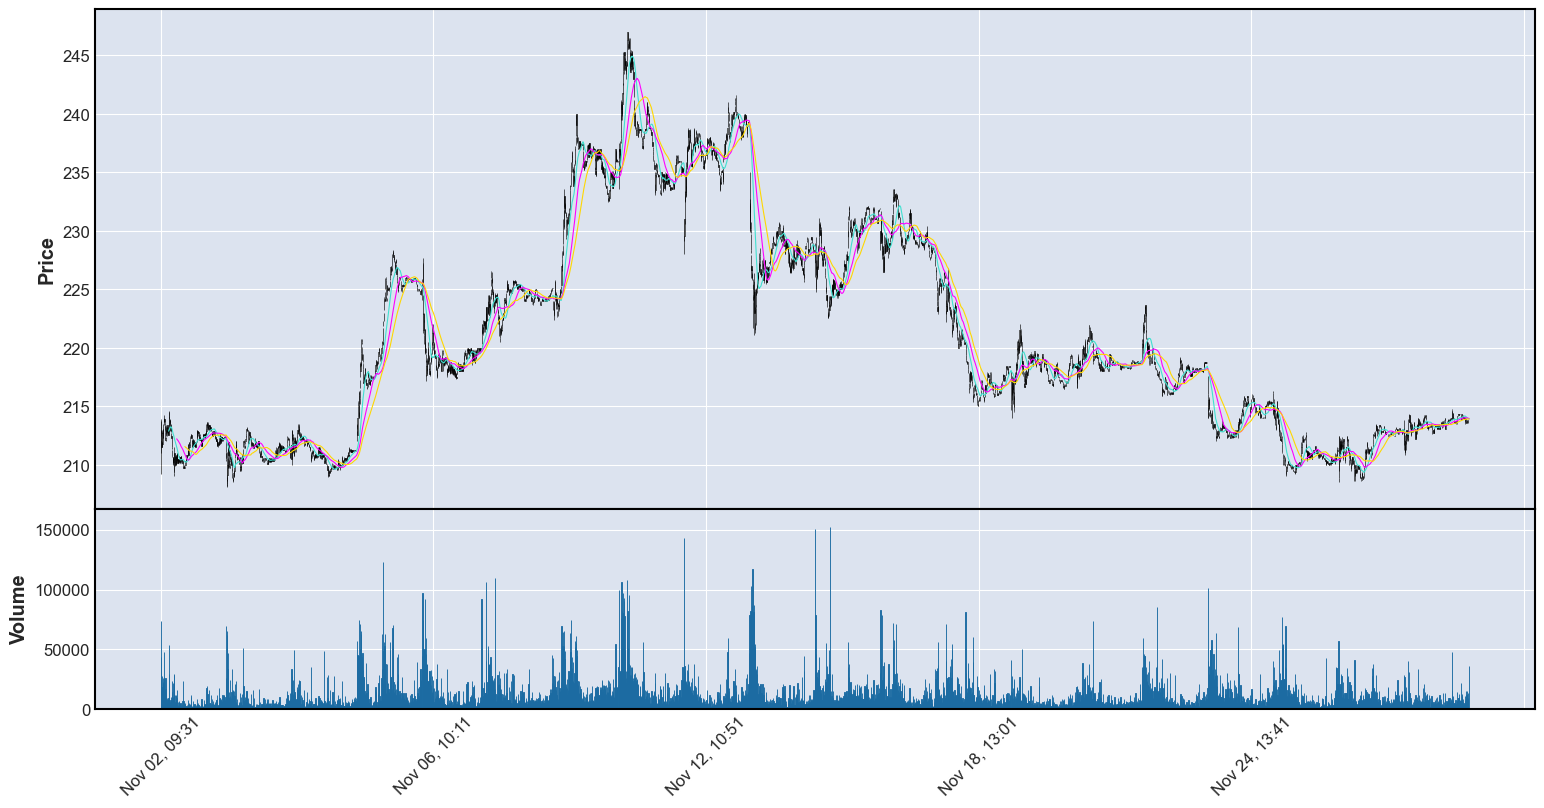

In [7]:
mpf.plot(c15_stocks_prices, type='candle', volume=True,mav=(30,60,90), figsize=(20,10))

Stock Code:  000799.XSHE
Looking at date: 2020-11-02
Number of positive: 121, Number of negative: 104
{'name': '000799.XSHE', 'date': '2020-11-02', 'final.pnl': 5.409343999998626, 'turnover': 14072.528214000002, 'num': 70, 'hld.period': 85}
Stock Code:  000799.XSHE
Looking at date: 2020-11-03
Number of positive: 117, Number of negative: 112
{'name': '000799.XSHE', 'date': '2020-11-03', 'final.pnl': 5.550374999998553, 'turnover': 14414.911887000007, 'num': 72, 'hld.period': 91}
Stock Code:  000799.XSHE
Looking at date: 2020-11-04
Number of positive: 108, Number of negative: 120
{'name': '000799.XSHE', 'date': '2020-11-04', 'final.pnl': 2.4668309999988622, 'turnover': 9605.066747000003, 'num': 48, 'hld.period': 61}
Stock Code:  000799.XSHE
Looking at date: 2020-11-05
Number of positive: 64, Number of negative: 48
{'name': '000799.XSHE', 'date': '2020-11-05', 'final.pnl': -2.0240790000013362, 'turnover': 13236.226204999999, 'num': 62, 'hld.period': 80}
Stock Code:  000799.XSHE
Looking at 

,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,29.202186,0.018081,55.306376,0.95,79.4,0.070494,1.384131


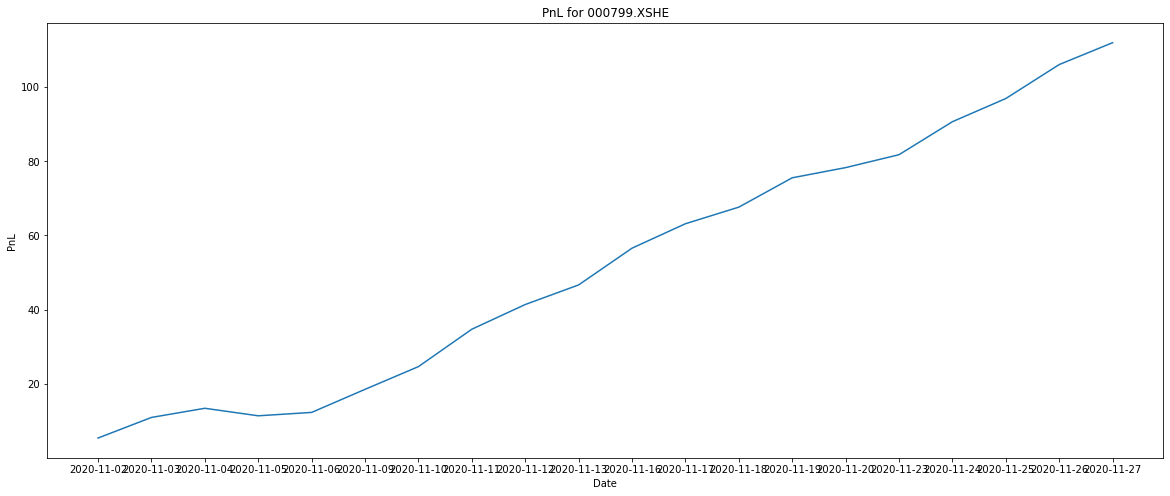

In [14]:
pd.DataFrame(PnL_Result_Plot(date_list, 4, start_date, end_date, '1m', threshold=0.001, transaction_fee=0.0003, tax=0.001), index=[0])

Stock Code:  000568.XSHE
Looking at date: 2020-11-02
Number of positive: 121, Number of negative: 110
{'name': '000568.XSHE', 'date': '2020-11-02', 'final.pnl': 9.484473999999778, 'turnover': 35650.753648000005, 'num': 101, 'hld.period': 136}
Stock Code:  000568.XSHE
Looking at date: 2020-11-03
Number of positive: 119, Number of negative: 112
{'name': '000568.XSHE', 'date': '2020-11-03', 'final.pnl': 14.895892999999944, 'turnover': 29795.587421, 'num': 83, 'hld.period': 124}
Stock Code:  000568.XSHE
Looking at date: 2020-11-04
Number of positive: 112, Number of negative: 113
{'name': '000568.XSHE', 'date': '2020-11-04', 'final.pnl': 9.676381999999819, 'turnover': 30706.362625999995, 'num': 84, 'hld.period': 101}
Stock Code:  000568.XSHE
Looking at date: 2020-11-05
Number of positive: 112, Number of negative: 120
{'name': '000568.XSHE', 'date': '2020-11-05', 'final.pnl': 12.424075999999701, 'turnover': 27632.447598, 'num': 75, 'hld.period': 107}
Stock Code:  000568.XSHE
Looking at date:

,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,82.497437,0.0,inf,1.0,79.15,0.161835,1.353127


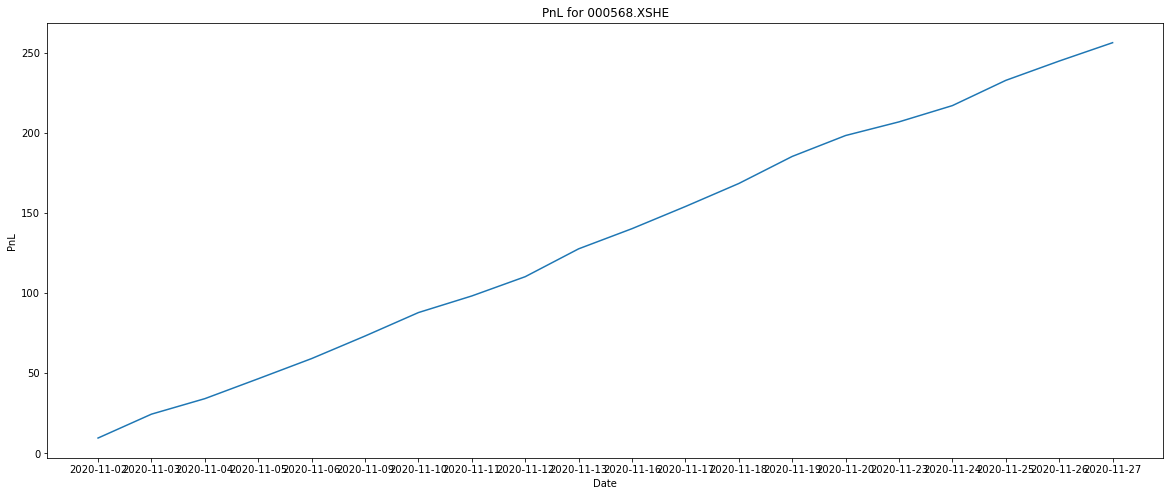

In [15]:
pd.DataFrame(PnL_Result_Plot(date_list, 0, start_date, end_date, '1m', threshold=0.001, transaction_fee=0.0003, tax=0.001), index=[0])

Stock Code:  000596.XSHE
Looking at date: 2020-11-02
Number of positive: 99, Number of negative: 127
{'name': '000596.XSHE', 'date': '2020-11-02', 'final.pnl': 10.873965999999797, 'turnover': 33944.791088000005, 'num': 80, 'hld.period': 99}
Stock Code:  000596.XSHE
Looking at date: 2020-11-03
Number of positive: 105, Number of negative: 122
{'name': '000596.XSHE', 'date': '2020-11-03', 'final.pnl': 19.99152099999958, 'turnover': 27454.95954300001, 'num': 65, 'hld.period': 96}
Stock Code:  000596.XSHE
Looking at date: 2020-11-04
Number of positive: 110, Number of negative: 111
{'name': '000596.XSHE', 'date': '2020-11-04', 'final.pnl': 11.273659000000038, 'turnover': 24508.460611000006, 'num': 58, 'hld.period': 67}
Stock Code:  000596.XSHE
Looking at date: 2020-11-05
Number of positive: 114, Number of negative: 114
{'name': '000596.XSHE', 'date': '2020-11-05', 'final.pnl': 20.73723599999977, 'turnover': 21235.25968399999, 'num': 48, 'hld.period': 83}
Stock Code:  000596.XSHE
Looking at d

,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,31.121006,0.0,inf,1.0,66.05,0.257446,1.389856


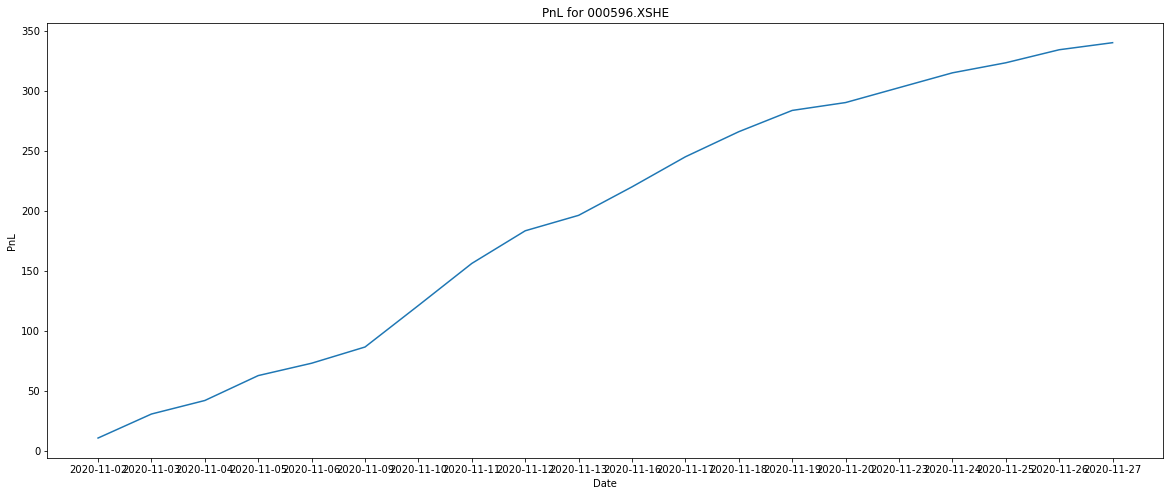

In [16]:
pd.DataFrame(PnL_Result_Plot(date_list, 1, start_date, end_date, '1m', threshold=0.001, transaction_fee=0.0003, tax=0.001), index=[0])

Stock Code:  000752.XSHE
Looking at date: 2020-11-02
Number of positive: 15, Number of negative: 23
{'name': '000752.XSHE', 'date': '2020-11-02', 'final.pnl': -0.306746999999997, 'turnover': 167.26350899999994, 'num': 26, 'hld.period': 38}
Stock Code:  000752.XSHE
Looking at date: 2020-11-03
Number of positive: 35, Number of negative: 35
{'name': '000752.XSHE', 'date': '2020-11-03', 'final.pnl': -1.248284999999993, 'turnover': 406.07387499999993, 'num': 66, 'hld.period': 69}
Stock Code:  000752.XSHE
Looking at date: 2020-11-04
Number of positive: 23, Number of negative: 20
{'name': '000752.XSHE', 'date': '2020-11-04', 'final.pnl': -0.6673369999999927, 'turnover': 246.78687699999998, 'num': 40, 'hld.period': 41}
Stock Code:  000752.XSHE
Looking at date: 2020-11-05
Number of positive: 27, Number of negative: 26
{'name': '000752.XSHE', 'date': '2020-11-05', 'final.pnl': -0.8889819999999902, 'turnover': 303.9424399999999, 'num': 49, 'hld.period': 50}
Stock Code:  000752.XSHE
Looking at dat

,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,-36.609813,-0.984129,-1.016127,0.0,57.9,-0.016691,1.144214


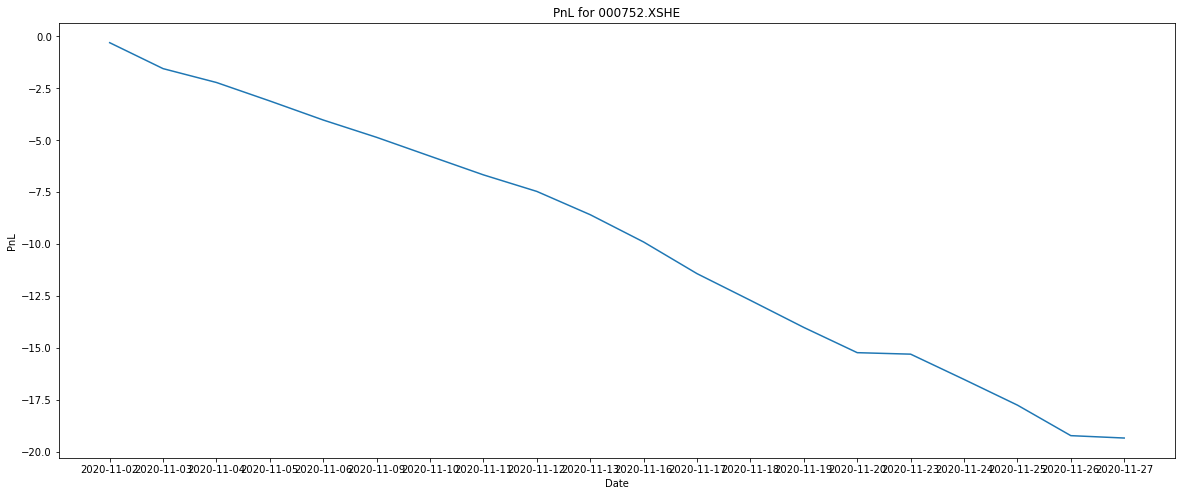

In [17]:
pd.DataFrame(PnL_Result_Plot(date_list, 3, start_date, end_date, '1m', threshold=0.001, transaction_fee=0.0003, tax=0.001), index=[0])